In [6]:
pip install scikit-fmm


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit-fmm-2022.3.26.tar.gz (432 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fmm: filename=scikit_fmm-2022.3.26-cp38-cp38-linux_x86_64.whl size=240838 sha256=bd84c5403cb48e5e57deced7e8a245de6f57167c6afe5619559af2d876c8c33d
  Stored in directory: /home/guillaume/.cache/pip/wheels/23/15/cf/ebbb283bbfae514442037733e0fd4b5c71482c6432f3e2f82e
Successfully built scikit-fmm
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from pandas import DataFrame
import skimage.io as io
from skimage.transform import resize
from skimage.measure import label, regionprops, marching_cubes_lewiner, mesh_surface_area
from skimage.draw import ellipse
from skimage import img_as_ubyte, img_as_bool
from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes
from skimage.util import invert
from tqdm.notebook import tqdm
import joblib
import time
import os
import glob
import skfmm

def Erosion3DimJ(input_img):
    tmp = np.zeros(input_img.shape, dtype=bool)
    for i in range(input_img.shape[0]):
        tmp[i, :, :] = binary_erosion(input_img[i, :, :])
    return tmp

# Find the 3D bounding box
def bbox2_3D(img, value):
    # From https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
    z = np.any(img == value, axis=(1, 2))
    c = np.any(img == value, axis=(0, 2))
    r = np.any(img == value, axis=(0, 1))
    zmin, zmax = np.where(z)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    rmin, rmax = np.where(r)[0][[0, -1]]
    return rmin, rmax, cmin, cmax, zmin, zmax

def Threshold(input_img, Th_value):
    tmp = np.zeros(input_img.shape, dtype=bool)
    if isinstance(Th_value, int):
        tmp[input_img == Th_value] = 1
    else:
        if isinstance(Th_value, float):
            tmp[input_img > 0. & input_img < 1.] = 1
        else:
            for th_val in range(len(Th_value)):
                tmp[input_img == Th_value[th_val]] = 1
    return tmp

# Define some parameters/variables
CHL = 3
MIT = 4
VAC = 2
CELL = 1
AIR = 5
ADJ = 6

# Voxel shape
voxel_dims = [0.05,0.02,0.02] #um
voxel_ratio = voxel_dims[0]/voxel_dims[1]
voxel_iso_dims = [0.05,0.05,0.05] #um

/usr/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/tmp/ipykernel_4060/792672769.py:8: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes
/tmp/ipykernel_4060/792672769.py:8: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes
/tmp/ipykernel_4060/792672769.py:8: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, distance_transform_edt, binary_fill_holes


[0 2 3 4 5 6]
(551, 804, 824)


/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


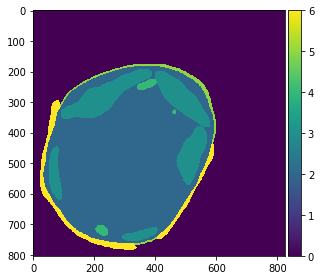

In [3]:
# Load image
#cell_img = img_as_ubyte(io.imread('/Volumes/Elements/Harwood_3D_cells/chickpea_cells/RHarwood-cell/D2C2/D2C2_merged-cropped.tif'))
cell_img = img_as_ubyte(io.imread('/home/guillaume/Seafile/NAS-data/D2C2_merged-cropped.tif'))

print(np.unique(cell_img))
print(cell_img.shape)
io.imshow(cell_img[200])

In [4]:
# Create isotropic image
print('Current anisotropic shape:', cell_img.shape)
print('New isotropic shape: ',(int(cell_img.shape[0]*voxel_ratio), cell_img.shape[1], cell_img.shape[2]))
cell_iso = np.zeros((int(cell_img.shape[0]*voxel_ratio), cell_img.shape[1], cell_img.shape[2]), dtype='uint8')

# Resize cropped image to have isotropic voxels
for i in range(cell_img.shape[1]):
    cell_iso[:,i,:] = resize(cell_img[:,i,:], output_shape=(int(cell_img.shape[0]*voxel_ratio), cell_img.shape[2]),
                             anti_aliasing=False, preserve_range=True, order=0)

del cell_img

Current anisotropic shape: (551, 804, 824)
New isotropic shape:  (1377, 804, 824)


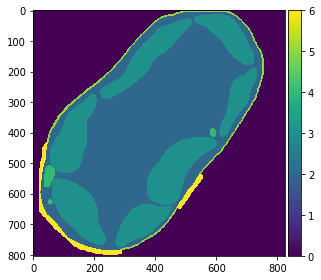

In [5]:
io.imshow(cell_iso[200])

In [6]:
## Extract the stacks for the surface to compute
# Mitochondria
# mito_stack = (cell_iso == MIT)
# mito_erosion = Erosion3DimJ(mito_stack)
# mito_edge = mito_stack ^ mito_erosion
# mito_pos = np.argwhere(mito_edge)
# del mito_erosion
# print(mito_pos.shape)

# Chloroplasts
chl_stack = (cell_iso == CHL)
chl_erosion = Erosion3DimJ(chl_stack)
chl_edge = chl_stack ^ chl_erosion
chl_pos = np.argwhere(chl_edge)
del chl_erosion
print(chl_pos.shape)

# Chl + Mito stack
#chl_mito = mito_stack + chl_stack

(2777129, 3)


/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


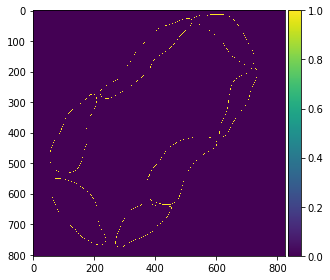

In [23]:
io.imshow(chl_edge[200].astype(int))

In [7]:
io.imshow(chl_mito[200].astype(int))

NameError: name 'chl_mito' is not defined

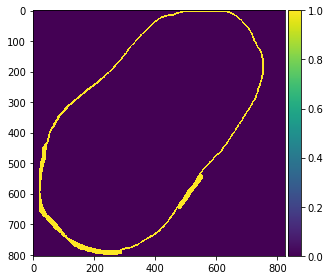

In [8]:
# All CW
all_cw_stack = Threshold(cell_iso, (AIR, ADJ))
io.imshow(all_cw_stack[200].astype(int))

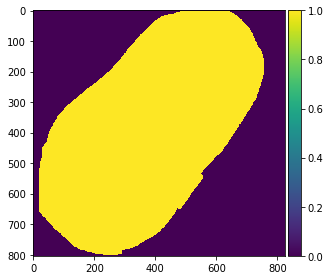

In [9]:
# Vacuole stack
vac_stack = binary_fill_holes(invert((cell_iso == 0)) + all_cw_stack)
io.imshow(vac_stack[200].astype(int))

In [19]:
# Inner cell wall
cw_erosion = Erosion3DimJ((vac_stack ^ all_cw_stack))
cw_edge = (vac_stack ^ all_cw_stack) ^ cw_erosion
cw_pos = np.argwhere(chl_edge)
del cw_erosion
print(cw_pos.shape)

(2777129, 3)


/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


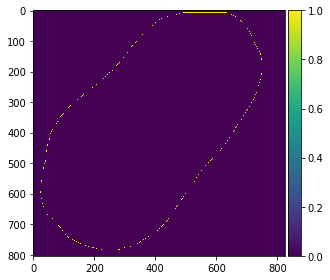

In [20]:
io.imshow(cw_edge[200].astype(int))

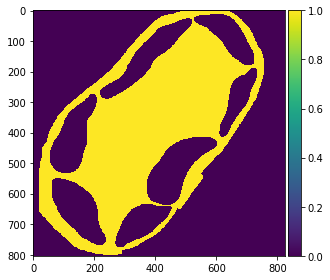

In [12]:
io.imshow((vac_stack ^ chl_stack)[200].astype(int))

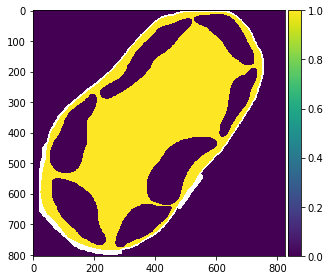

In [13]:
# Create masked array
#air_masked_array = np.ma.masked_array(chl_stack, all_cw_stack)
air_masked_array = np.ma.masked_array((vac_stack ^ chl_stack), all_cw_stack)
io.imshow(air_masked_array[200].astype(int))


In the image above, 0s are where no distances are computed, 'White' is the mask, so it cannot cross I think, and 1s are within where distances are computed. For the distance from the CW to the CHLs and MIT, chl and mits are in white, and the whole cell has values of 1. Here, for the distance from CHL to CW, 

In [14]:
# compute geodesic distance
t0 = time.time()
D_geo = skfmm.distance(air_masked_array, dx=voxel_iso_dims)
print('D_geo processing time:',str(np.round((time.time()-t0), 1)),'s')

D_geo processing time: 495.3 s


(1377, 804, 824)
float64


/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


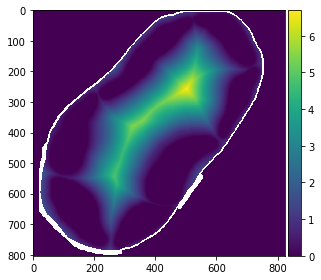

In [15]:
print(D_geo.shape)
print(D_geo.dtype)
io.imshow(D_geo[200])

In [16]:
# Compute Euclidean distance
t0 = time.time()
D_euc = np.ma.masked_array(distance_transform_edt((vac_stack ^ chl_stack), sampling=voxel_iso_dims), all_cw_stack, dtype="float32")
print('D_euc processing time:',str(np.round((time.time()-t0), 1)),'s')

D_euc processing time: 154.9 s


(1377, 804, 824)
float32


/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


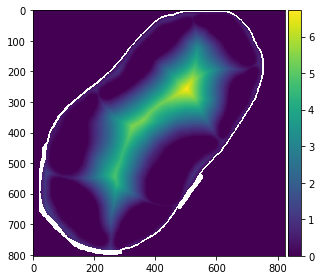

In [17]:
print(D_euc.shape)
print(D_euc.dtype)
io.imshow(D_euc[200])

In [21]:
# Create dictionnary and DataFrame of results
results_cw = {'L_geo': np.asarray(D_geo[cw_edge]),
               'L_euc': np.asarray(D_euc[cw_edge])}
results_cw_df = DataFrame(results_cw)

In [22]:
results_cw_df

,L_geo,L_euc
0,3.293063,0.701783
1,3.253698,0.701783
2,3.214606,0.701783
3,3.175799,0.701783
4,3.137293,0.701783
...,...,...
2133910,0.638029,0.659545
2133911,0.643347,0.665207
2133912,0.650850,0.674537
2133913,0.660758,0.683740


In [24]:
results_cw_df.to_csv('/home/guillaume/Seafile/NAS-data/D2C2_merged-cropped-CHL-to-CW-dist-txt', sep='\t', encoding='utf-8')


In [32]:
# New array for Sc
cw_near_chl_stack = (D_euc < 0.75)
cw_near_chl_stack.shape

(1377, 804, 824)

/usr/lib64/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


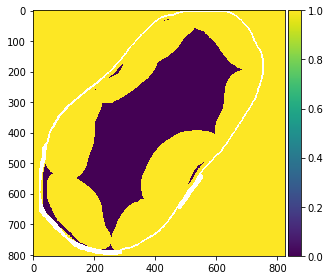

In [33]:
io.imshow(cw_near_chl_stack[200].astype(int))

In [27]:
## NOT EDITED

# Export results to text file
results_mit_df.to_csv('/home/guillaume/Downloads/RHarwood-cell/'+sample_name+'/rw_results/'+sample_name+'_random_walk_for_all_mit-'+str(j)+'.txt', sep='\t', encoding='utf-8')

# Create dictionnary and DataFrame of results
results_mit = {'L_geo': np.asarray(D_geo[mito_edge]),
               'L_euc': np.asarray(D_euc[mito_edge])}
results_mit_df = DataFrame(results)
# Export results to text file
results_mit_df.to_csv('/home/guillaume/Downloads/RHarwood-cell/'+sample_name+'/rw_results/'+sample_name+'_random_walk_for_all_mit-'+str(j)+'.txt', sep='\t', encoding='utf-8')

True